In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys, glob, json
import os, sys, random, ssl, csv
import urllib, urllib.request
import pysftp #pip install pysftp
import warnings
warnings.filterwarnings("default")

sys.path.append('/Users/manishrai/cocoapi/')
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval

In [106]:
# Input parameters
round_number = 'round1'
species_list = ['wildebeest', 'zebra', 'buffalo', 'hartebeest', 'gazelleThomsons', 'elephant', 'eland', 'lionFemale']
species = species_list[5]

In [107]:
gsss = pd.read_csv("/Users/manishrai/Desktop/Exp3/GoldStandardBoundBoxCoord_temp.csv")
print(set(gsss['class']))
gsss.head()

{'vervetMonkey', 'ostrich', 'cheetah', 'rodents', 'koriBustard', 'serval', 'dikDik', 'jackal', 'rhinoceros', 'bushbuck', 'warthog', 'waterbuck', 'hyenaSpotted', 'gazelleGrants', 'zebra', 'reedbuck', 'hartebeest', 'baboon', 'impala', 'mongoose', 'human', 'otherBird', 'hippopotamus', 'eland', 'leopard', 'buffalo', 'aardwolf', 'aardvark', 'elephant', 'porcupine', 'wildebeest', 'guineaFowl', 'gazelleThomsons', 'giraffe', 'secretaryBird', 'topi', 'hare'}


,filename,width,height,class,xmin,ymin,xmax,ymax
0,ASG000dz24.jpg,2048,1536,impala,1141,883,1227,977
1,ASG000dz24.jpg,2048,1536,impala,1340,876,1381,925
2,ASG000dz24.jpg,2048,1536,impala,1448,803,1538,1042
3,ASG000dz24.jpg,2048,1536,impala,1382,763,1485,1080
4,ASG000c7hr.jpg,2048,1536,wildebeest,1987,680,2048,751


In [108]:
# Filtering the single species images
df_img_species_cnt = pd.DataFrame(gsss[['filename', 'class']].drop_duplicates()
                                .groupby(by='filename', as_index=False).count())\
                                .rename(columns={'class':'num_species'})
df_img_species_cnt = df_img_species_cnt[df_img_species_cnt['num_species']==1]
print(set(df_img_species_cnt['num_species']))
lst_img_species_cnt = list(df_img_species_cnt['filename'])

df_gsss_single_species = gsss.loc[gsss['filename'].isin(lst_img_species_cnt)]
print(df_gsss_single_species.shape)
print("Single Species images: {0}".format(len(lst_img_species_cnt)))
df_gsss_single_species.head()

{1}
(14955, 8)
Single Species images: 3524


,filename,width,height,class,xmin,ymin,xmax,ymax
0,ASG000dz24.jpg,2048,1536,impala,1141,883,1227,977
1,ASG000dz24.jpg,2048,1536,impala,1340,876,1381,925
2,ASG000dz24.jpg,2048,1536,impala,1448,803,1538,1042
3,ASG000dz24.jpg,2048,1536,impala,1382,763,1485,1080
4,ASG000c7hr.jpg,2048,1536,wildebeest,1987,680,2048,751


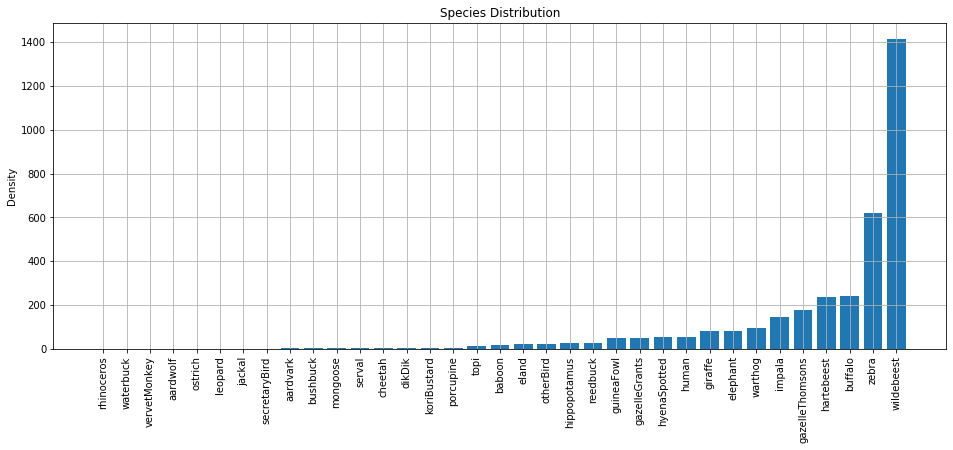

In [109]:
# getting the species distribution in single species images
df_class_freq = pd.DataFrame(df_gsss_single_species[['filename', 'class']].drop_duplicates()
             .groupby(by='class', as_index=False).count())\
             .rename(columns={'filename':'freq'})
df_class_freq = df_class_freq.sort_values(by='freq')

# Plot the frequency
plt.figure(figsize=(16, 6))
plt.bar(df_class_freq['class'], df_class_freq['freq'])#/sum(df_class_freq['freq']))
plt.xticks(rotation='vertical')
plt.grid()
plt.title('Species Distribution')
plt.ylabel('Density')
plt.show()

In [110]:
print("Distinct images in the GSSS csv: {0}".format(sum(df_class_freq['freq'])))
print("Distinct images in the schneider images: {0}".format(int((6250/2)+(568/2))))

Distinct images in the GSSS csv: 3524
Distinct images in the schneider images: 3409


In [111]:
image_filename1 = glob.glob('/Users/manishrai/Desktop/UMN/Research/Zooniverse/Data/Schneider_Data/images/train/*jpg')
image_filename2 = glob.glob('/Users/manishrai/Desktop/UMN/Research/Zooniverse/Data/Schneider_Data/images/test/*jpg')
image_filename = image_filename1 + image_filename2
len(image_filename)

3393

In [112]:
image_list_jpg = [image.split('/')[-1] for image in image_filename]
len(set(df_gsss_single_species['filename']).intersection(set(image_list_jpg)))

2979

### all_image.csv

In [113]:
df_all_images = pd.read_csv('/Users/manishrai/Desktop/UMN/Research/Zooniverse/camera-trap-detection/training_demo/Data/all_images.csv')
gsss_images_w_bbox = [img.split('.')[0] for img in set(df_gsss_single_species['filename'])]
df_all_images_needed = df_all_images.loc[df_all_images['CaptureEventID'].isin(gsss_images_w_bbox)]
df_all_images_needed = df_all_images_needed.sort_values(by=['CaptureEventID', 'URL_Info'])
df_all_images_needed = df_all_images_needed.drop_duplicates(subset='CaptureEventID', keep='first')
print(df_all_images_needed.shape)
df_all_images_needed.head()

(3524, 2)


,CaptureEventID,URL_Info
1627558,ASG000b3xp,S4/I10/I10_R2/S4_I10_R2_IMAG1709.JPG
1626214,ASG000b45v,S4/I10/I10_R2/S4_I10_R2_IMAG0365.JPG
1629306,ASG000b48a,S4/I10/I10_R2/S4_I10_R2_IMAG3457.JPG
1630095,ASG000b4c2,S4/I10/I10_R2/S4_I10_R2_IMAG4246.JPG
1626752,ASG000b4cg,S4/I10/I10_R2/S4_I10_R2_IMAG0903.JPG


### Download the images

In [114]:
hostname = "login.msi.umn.edu"
username = "rai00007"       
password = "xxxx"

In [115]:
# Filtering out the images that are used in training the model
l = []
with open("../data/LILA/msi_snapshot_serengeti_new.csv",'r') as f:
    rd = csv.reader(f)
    for val in rd:
        l.append(val)
        
l = l[0]

In [116]:
df_all_images_needed['filename'] = [img.split('.')[0] for img in df_all_images_needed['URL_Info']]
df_all_images_needed['CaptureEventID'] = [CaptureEventID+'.jpg' for CaptureEventID in df_all_images_needed['CaptureEventID']]
print(df_all_images_needed.shape)
df_all_images_needed = df_all_images_needed.loc[~df_all_images_needed['filename'].isin(l)]
print(df_all_images_needed.shape)
df_all_images_needed.head()

(3524, 3)
(3524, 3)


,CaptureEventID,URL_Info,filename
1627558,ASG000b3xp.jpg,S4/I10/I10_R2/S4_I10_R2_IMAG1709.JPG,S4/I10/I10_R2/S4_I10_R2_IMAG1709
1626214,ASG000b45v.jpg,S4/I10/I10_R2/S4_I10_R2_IMAG0365.JPG,S4/I10/I10_R2/S4_I10_R2_IMAG0365
1629306,ASG000b48a.jpg,S4/I10/I10_R2/S4_I10_R2_IMAG3457.JPG,S4/I10/I10_R2/S4_I10_R2_IMAG3457
1630095,ASG000b4c2.jpg,S4/I10/I10_R2/S4_I10_R2_IMAG4246.JPG,S4/I10/I10_R2/S4_I10_R2_IMAG4246
1626752,ASG000b4cg.jpg,S4/I10/I10_R2/S4_I10_R2_IMAG0903.JPG,S4/I10/I10_R2/S4_I10_R2_IMAG0903


Merge with single species gsss images

In [117]:
df_gsss_single_species2 = pd.merge(left=df_gsss_single_species,
                                  right=df_all_images_needed,
                                  left_on=df_gsss_single_species['filename'],
                                  right_on=df_all_images_needed['CaptureEventID'],
                                  how='inner'
                                 )\
                                  .drop(columns=['key_0', 'CaptureEventID'])

print(df_gsss_single_species2.shape)
df_gsss_single_species2.head()

(14955, 10)


,filename_x,width,height,class,xmin,ymin,xmax,ymax,URL_Info,filename_y
0,ASG000dz24.jpg,2048,1536,impala,1141,883,1227,977,S4/J01/J01_R1/S4_J01_R1_IMAG0111.JPG,S4/J01/J01_R1/S4_J01_R1_IMAG0111
1,ASG000dz24.jpg,2048,1536,impala,1340,876,1381,925,S4/J01/J01_R1/S4_J01_R1_IMAG0111.JPG,S4/J01/J01_R1/S4_J01_R1_IMAG0111
2,ASG000dz24.jpg,2048,1536,impala,1448,803,1538,1042,S4/J01/J01_R1/S4_J01_R1_IMAG0111.JPG,S4/J01/J01_R1/S4_J01_R1_IMAG0111
3,ASG000dz24.jpg,2048,1536,impala,1382,763,1485,1080,S4/J01/J01_R1/S4_J01_R1_IMAG0111.JPG,S4/J01/J01_R1/S4_J01_R1_IMAG0111
4,ASG000c7hr.jpg,2048,1536,wildebeest,1987,680,2048,751,S4/B07/B07_R2/S4_B07_R2_IMAG0289.JPG,S4/B07/B07_R2/S4_B07_R2_IMAG0289


In [118]:
# Creating csv in the format:
# filename,class,xmin,ymin,xmax,ymax
# S4/F13/F13_R1/S4_F13_R1_IMAG0526,zebra,0.0,0.38,0.12,0.54
df_gsss_single_species3 = df_gsss_single_species2.copy()
df_gsss_single_species3['xmin']=df_gsss_single_species3['xmin']/df_gsss_single_species3['width']
df_gsss_single_species3['ymin']=df_gsss_single_species3['ymin']/df_gsss_single_species3['height']
df_gsss_single_species3['xmax']=df_gsss_single_species3['xmax']/df_gsss_single_species3['width']
df_gsss_single_species3['ymax']=df_gsss_single_species3['ymax']/df_gsss_single_species3['height']

df_gsss_single_species3 = df_gsss_single_species3\
                  .rename(columns={'filename_y':'filename'})[['filename','class','xmin','ymin','xmax','ymax']]
df_gsss_single_species3['filename'] = [name.split('.')[0] for name in df_gsss_single_species3['filename']]
df_gsss_single_species3.head()

,filename,class,xmin,ymin,xmax,ymax
0,S4/J01/J01_R1/S4_J01_R1_IMAG0111,impala,0.557129,0.574870,0.599121,0.636068
1,S4/J01/J01_R1/S4_J01_R1_IMAG0111,impala,0.654297,0.570312,0.674316,0.602214
2,S4/J01/J01_R1/S4_J01_R1_IMAG0111,impala,0.707031,0.522786,0.750977,0.678385
3,S4/J01/J01_R1/S4_J01_R1_IMAG0111,impala,0.674805,0.496745,0.725098,0.703125
4,S4/B07/B07_R2/S4_B07_R2_IMAG0289,wildebeest,0.970215,0.442708,1.000000,0.488932


In [119]:
# Creating 5 different CSVs for the top 5 species
# df_wildebeest = df_gsss_single_species2.loc[df_gsss_single_species2['class']=='wildebeest']
# df_wildebeest.to_csv('wildebeest.csv', index=False)

# df_zebra = df_gsss_single_species2.loc[df_gsss_single_species2['class']=='zebra']
# df_zebra.to_csv('zebra.csv', index=False)

# df_buffalo = df_gsss_single_species2.loc[df_gsss_single_species2['class']=='buffalo']
# df_buffalo.to_csv('buffalo.csv', index=False)

# df_hartebeest = df_gsss_single_species2.loc[df_gsss_single_species2['class']=='hartebeest']
# df_hartebeest.to_csv('hartebeest.csv', index=False)

# df_gazelleThomsons = df_gsss_single_species2.loc[df_gsss_single_species2['class']=='gazelleThomsons']
# df_gazelleThomsons.to_csv('gazelleThomsons.csv', index=False)

**Get Label Map**

In [120]:
# Bringing in the label map
sys.path.append('/Users/manishrai/Desktop/UMN/Research/Zooniverse/my_workspace/training-species-detection/')
import dataset_tools.data_prep_utils as dataprep_utils

label_map_json = '/Users/manishrai/Desktop/UMN/Research/Zooniverse/my_workspace/training-species-detection/Data/label_map.json'
label_map = dataprep_utils.get_label_map_from_json(label_map_json)
label_map = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
label_map.columns = ['class', 'label_map']
label_map = label_map.sort_values(by='label_map')
label_map.tail()

,class,label_map
39,genet,44
27,caracal,45
13,rhinoceros,46
22,reptiles,47
35,zorilla,48


### Ground Truth data prep for COCO evaluation

In [121]:
df_species_gsss = df_gsss_single_species2[df_gsss_single_species2['class']==species]
# TODO - Exclude data used in training

df_species_gsss['filename_x'] = [name.split('.')[0] for name in df_species_gsss['filename_x']]
df_species_gsss['filename_y'] = [name.split('.')[0] for name in df_species_gsss['filename_y']]
df_species_gsss['URL_Info'] = [name.split('.')[0] for name in df_species_gsss['URL_Info']]

df_species_gsss['xmin'] = round((df_species_gsss['xmin']/df_species_gsss['width'])*1000,2)
df_species_gsss['xmax'] = round((df_species_gsss['xmax']/df_species_gsss['width'])*1000,2)
df_species_gsss['ymin'] = round((df_species_gsss['ymin']/df_species_gsss['height'])*750,2)
df_species_gsss['ymax'] = round((df_species_gsss['ymax']/df_species_gsss['height'])*750,2)

df_species_gsss['box_width'] = df_species_gsss['xmax'] - df_species_gsss['xmin']
df_species_gsss['box_height'] = df_species_gsss['ymax'] - df_species_gsss['ymin']
df_species_gsss['box_id'] = df_species_gsss.index
df_species_gsss = df_species_gsss.reset_index().drop(columns='index')

print(df_species_gsss.shape)

# Bringing in the label_map
class_name = list(df_species_gsss['class'])[0]
class_number = int(label_map.loc[label_map['class']==class_name]['label_map'])
df_species_gsss['category_id'] = class_number
df_species_gsss['area'] = df_species_gsss['box_width']*df_species_gsss['box_height']
df_species_gsss.head()

(123, 13)


/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,filename_x,width,height,class,xmin,ymin,xmax,ymax,URL_Info,filename_y,box_width,box_height,box_id,category_id,area
0,ASG000fcaz,2048,1536,elephant,0.49,0.49,430.66,750.00,S4/I12/I12_R2/S4_I12_R2_IMAG7359,S4/I12/I12_R2/S4_I12_R2_IMAG7359,430.17,749.51,54,11,322416.7167
1,ASG000fbzg,2048,1536,elephant,823.73,0.49,999.51,227.05,S4/I12/I12_R1/S4_I12_R1_IMAG0026,S4/I12/I12_R1/S4_I12_R1_IMAG0026,175.78,226.56,125,11,39824.7168
2,ASG000crwn,2048,1536,elephant,203.12,285.16,631.84,589.36,S4/O06/O06_R2/S4_O06_R2_IMAG1163,S4/O06/O06_R2/S4_O06_R2_IMAG1163,428.72,304.20,971,11,130416.6240
3,ASG000crwn,2048,1536,elephant,89.36,262.70,418.95,481.45,S4/O06/O06_R2/S4_O06_R2_IMAG1163,S4/O06/O06_R2/S4_O06_R2_IMAG1163,329.59,218.75,972,11,72097.8125
4,ASG000dfno,2048,1536,elephant,9.28,0.49,1000.00,750.00,S4/O10/O10_R1/S4_O10_R1_IMAG0345,S4/O10/O10_R1/S4_O10_R1_IMAG0345,990.72,749.51,991,11,742554.5472


In [14]:
# %%writefile ../data_prep/COCO_Format_Encoder.py


import pandas as pd
import json, csv

def convert_groundtruth_to_coco_format(df_species_gsss, label_map):
    """
    This function takes in a groundtruth dataframe and converts it into COCO json format
    Input CSV format:
    filename,width,height,class,xmin,ymin,xmax,ymax,filename_x,box_width,box_height,box_id,category_id,area
    S1/I07/I07_R1/S1_I07_R1_PICT1979,2048,1536,elephant,1.46,0.00,806.44,683.60,S1/I07/I07_R1/S1_I07_R1_PICT1979,804.98,683.60,8,11,550284.3280
    
    return: Groundtruth dictionary. This can be loaded into a COCO format JSON
    """
    GT = {}
    # info
    GT['info'] = {
        "description": "Schneider data",
        "version": "1.0",
        "year": 2012
    }

    # Licenses
    GT['licenses'] = [
        {
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        },
        {
            "url": "http://creativecommons.org/licenses/by-nc/2.0/",
            "id": 2,
            "name": "Attribution-NonCommercial License"
        }]

    # images
    GT['images'] = []
    df_temp = df_species_gsss[['URL_Info', 'filename_x']].drop_duplicates()
    for i in range(df_temp.shape[0]):
        GT['images'].append({
            'file_name': str(df_temp.iloc[i]['URL_Info']) + '.JPG',
            'height': 750,
            'width': 1000,
            'id': str(df_temp.iloc[i]['filename_x'])
        })

    # categories from label map
    GT['categories'] = []    
    for i in range(label_map.shape[0]):
        GT['categories'].append({
            'supercategory': 'Animal',
            'id': int(label_map.iloc[i]['label_map']),
            'name': str(label_map.iloc[i]['class'])
    })

    # annotations
    GT['annotations'] = []

    for i in range(df_species_gsss.shape[0]):
        df_inter = df_species_gsss.iloc[i]
        GT['annotations'].append({'area':float(df_inter['area']),
                                  'iscrowd': 0,
                                  'image_id': str(df_inter['filename_x']),
                                  'bbox': [df_inter['xmin'], df_inter['ymin'], df_inter['box_width'], df_inter['box_height']],
                                  'category_id': int(df_inter['category_id']),
                                  'id': int(df_inter['box_id'])
                                 })
    return GT
    
def convert_results_to_coco_format(df_pred_gt_thres):
    """
    This function takes in the prediction dataframe and converts it to COCO results format.
    The imput data format:
    filename,labels,labels_class,score,xmax,xmin,ymax,ymin,box_width,box_height,box_id
    S3/F03/F03_R11/S3_F03_R11_IMAG0088,11.0,elephant,1.0,996.81,839.09,429.46,272.91,157.72,156.55,373
    """
    results = []
    for i in range(df_pred_gt_thres.shape[0]):
        df_temp = df_pred_gt_thres.iloc[i]
        results.append({
            "bbox": [df_temp['xmin'], df_temp['ymin'], df_temp['box_width'], df_temp['box_height']],
            "category_id": int(df_temp['labels']),
            "image_id": df_temp['filename'],
            "score": df_temp['score']
        })
    return results
    
# Write to JSON
# with open('./Exp3/annotations_{0}.json'.format(species), 'w') as outfile:
#     json.dump(GT, outfile)

### Predictions

In [26]:
# detection_threshold = list(np.arange(0.10, 0.95, 0.05))
detection_threshold = [0.5]
df_pred = pd.read_csv("/Users/manishrai/Desktop/Exp3/{0}.csv".format(round_number))

# flter out scores>=0.5
for threshold in detection_threshold:
    df_pred_gt_thres = df_pred.loc[df_pred['score']>=round(threshold, 2)]
    df_pred_gt_thres['xmin'] = df_pred_gt_thres['xmin']*1000
    df_pred_gt_thres['xmax'] = df_pred_gt_thres['xmax']*1000
    df_pred_gt_thres['ymin'] = df_pred_gt_thres['ymin']*750
    df_pred_gt_thres['ymax'] = df_pred_gt_thres['ymax']*750
    df_pred_gt_thres['box_width'] = df_pred_gt_thres['xmax'] - df_pred_gt_thres['xmin']
    df_pred_gt_thres['box_height'] = df_pred_gt_thres['ymax'] - df_pred_gt_thres['ymin']
    df_pred_gt_thres['filename'] = [name.split('/')[-1].split('.')[0] for name in df_pred_gt_thres['filename']]
    df_pred_gt_thres = df_pred_gt_thres.round({'xmax': 2, 
                                               'xmin': 2, 
                                               'ymin': 2, 
                                               'ymax': 2,
                                               'box_width': 2,
                                               'box_height': 2
                                              })
    # filter out for ground truth GarelleThompson images
    lst_gazelle_images = list(set(df_species_gsss['filename_x']))
    df_pred_gt_thres = df_pred_gt_thres.loc[df_pred_gt_thres['filename'].isin(lst_gazelle_images)]

    df_pred_gt_thres['box_id'] = df_pred_gt_thres.index
    df_pred_gt_thres = df_pred_gt_thres.reset_index().drop(columns='index')

    # Create results format
    results = []
    for i in range(df_pred_gt_thres.shape[0]):
        df_temp = df_pred_gt_thres.iloc[i]
        results.append({
            "bbox": [df_temp['xmin'], df_temp['ymin'], df_temp['box_width'], df_temp['box_height']],
            "category_id": int(df_temp['labels']),
            "image_id": df_temp['filename'],
            "score": df_temp['score']
        })

    # Write to JSON
    with open('./Exp3/results_{2}_{0}_{1}.json'.format(round_number, round(threshold, 2), species), 'w') as outfile:
        json.dump(results, outfile)

/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Callable functions for converting data to COCO detetion format

In [38]:
# Temporarily defining groundtruth and results data
round_number = 'round0_LILA_new'
gt_path = '/Users/manishrai/Desktop/Exp3/Groundtruth_LILA_Bbox_new_annotation.csv'
result_path = '/Users/manishrai/Desktop/Exp3/{0}Bbox_results.csv'.format(round_number)
species_list = ['wildebeest', 'zebra', 'buffalo', 'hartebeest', 'gazelleThomsons', 'elephant']
species = species_list[5]

In [39]:
df_LILA_new_add = pd.read_csv(gt_path)
# Filter out single species images
df_img_species_cnt = pd.DataFrame(df_LILA_new_add[['filename', 'class']].drop_duplicates()
                                .groupby(by='filename', as_index=False).count())\
                                .rename(columns={'class':'num_species'})
df_img_species_cnt = df_img_species_cnt[df_img_species_cnt['num_species']==1]
# print(set(df_img_species_cnt['num_species']))
lst_img_species_cnt = list(set(df_img_species_cnt['filename']))

df_species_gsss = df_LILA_new_add[df_LILA_new_add['class']==species]
df_species_gsss = df_species_gsss[df_species_gsss['filename'].isin(lst_img_species_cnt)]
df_species_gsss.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
8,S1/I07/I07_R1/S1_I07_R1_PICT1979,2048,1536,elephant,3.000000,0.000000,1651.581909,1400.013184
12,S6/L04/L04_R1/S6_L04_R1_IMAG0521,2048,1536,elephant,1.600061,0.799993,2048.000000,1534.399902
15,S5/G12/G12_R2/S5_G12_R2_IMAG0284,2048,1536,elephant,536.000000,2.000000,2048.000000,1535.999878
16,S2/G01/G01_R1/S2_G01_R1_PICT0526,2048,1536,elephant,1187.979492,0.000000,1617.117432,853.042603
17,S2/G01/G01_R1/S2_G01_R1_PICT0526,2048,1536,elephant,1339.747925,0.000000,2048.000000,1439.000000


In [40]:
# TODO - Exclude data used in training
df_species_gsss['xmin'] = round((df_species_gsss['xmin']/df_species_gsss['width'])*1000,2)
df_species_gsss['xmax'] = round((df_species_gsss['xmax']/df_species_gsss['width'])*1000,2)
df_species_gsss['ymin'] = round((df_species_gsss['ymin']/df_species_gsss['height'])*750,2)
df_species_gsss['ymax'] = round((df_species_gsss['ymax']/df_species_gsss['height'])*750,2)
df_species_gsss['filename_x'] = df_species_gsss['filename']
df_species_gsss['URL_Info'] = df_species_gsss['filename']

df_species_gsss['box_width'] = df_species_gsss['xmax'] - df_species_gsss['xmin']
df_species_gsss['box_height'] = df_species_gsss['ymax'] - df_species_gsss['ymin']
df_species_gsss['box_id'] = df_species_gsss.index
df_species_gsss = df_species_gsss.reset_index().drop(columns=['index', 'filename'])

print(df_species_gsss.shape)

# Bringing in the label_map
class_name = list(df_species_gsss['class'])[0]
class_number = int(label_map.loc[label_map['class']==class_name]['label_map'])
df_species_gsss['category_id'] = class_number
df_species_gsss['area'] = df_species_gsss['box_width']*df_species_gsss['box_height']
df_species_gsss.head()

(18245, 12)


,width,height,class,xmin,ymin,xmax,ymax,filename_x,URL_Info,box_width,box_height,box_id,category_id,area
0,2048,1536,elephant,1.46,0.00,806.44,683.60,S1/I07/I07_R1/S1_I07_R1_PICT1979,S1/I07/I07_R1/S1_I07_R1_PICT1979,804.98,683.60,8,11,550284.3280
1,2048,1536,elephant,0.78,0.39,1000.00,749.22,S6/L04/L04_R1/S6_L04_R1_IMAG0521,S6/L04/L04_R1/S6_L04_R1_IMAG0521,999.22,748.83,12,11,748245.9126
2,2048,1536,elephant,261.72,0.98,1000.00,750.00,S5/G12/G12_R2/S5_G12_R2_IMAG0284,S5/G12/G12_R2/S5_G12_R2_IMAG0284,738.28,749.02,15,11,552986.4856
3,2048,1536,elephant,580.07,0.00,789.61,416.52,S2/G01/G01_R1/S2_G01_R1_PICT0526,S2/G01/G01_R1/S2_G01_R1_PICT0526,209.54,416.52,16,11,87277.6008
4,2048,1536,elephant,654.17,0.00,1000.00,702.64,S2/G01/G01_R1/S2_G01_R1_PICT0526,S2/G01/G01_R1/S2_G01_R1_PICT0526,345.83,702.64,17,11,242993.9912


In [41]:
sys.path.append('/Users/manishrai/Desktop/UMN/Research/Zooniverse/camera-trap-detection/')
import data_prep.COCO_Format_Encoder as cfe

df_species_above_area_threshold = df_species_gsss[df_species_gsss['area']>=0]
GT = cfe.convert_groundtruth_to_coco_format(df_species_above_area_threshold, label_map)

In [42]:
min(df_species_above_area_threshold.area)

3.356699999999988

In [43]:
# preparing the results dataset
detection_threshold = [0.5]
df_pred = pd.read_csv(result_path)

# flter out scores>=0.5
for threshold in detection_threshold:
    df_pred_gt_thres = df_pred.loc[df_pred['score']>=round(threshold, 2)]
    df_pred_gt_thres['xmin'] = df_pred_gt_thres['xmin']*1000
    df_pred_gt_thres['xmax'] = df_pred_gt_thres['xmax']*1000
    df_pred_gt_thres['ymin'] = df_pred_gt_thres['ymin']*750
    df_pred_gt_thres['ymax'] = df_pred_gt_thres['ymax']*750
    df_pred_gt_thres['box_width'] = df_pred_gt_thres['xmax'] - df_pred_gt_thres['xmin']
    df_pred_gt_thres['box_height'] = df_pred_gt_thres['ymax'] - df_pred_gt_thres['ymin']
#     df_pred_gt_thres['filename'] = [name.split('/')[-1].split('.')[0] for name in df_pred_gt_thres['filename']]
    df_pred_gt_thres = df_pred_gt_thres.round({'xmax': 2, 
                                               'xmin': 2, 
                                               'ymin': 2, 
                                               'ymax': 2,
                                               'box_width': 2,
                                               'box_height': 2
                                              })
    # filter out for ground truth Species images
    lst_species_images = list(set(df_species_above_area_threshold['filename_x']))
    df_pred_gt_thres = df_pred_gt_thres.loc[df_pred_gt_thres['filename'].isin(lst_species_images)]

    df_pred_gt_thres['box_id'] = df_pred_gt_thres.index
    df_pred_gt_thres = df_pred_gt_thres.reset_index().drop(columns='index')

# df_pred_gt_thres.head()

/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/manishrai/venv_py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [44]:
results = cfe.convert_results_to_coco_format(df_pred_gt_thres)
print(len(results))

15995


In [27]:
# # Write to ground truth to JSON
with open('./Exp3/annotations_{0}.json'.format(species), 'w') as outfile:
    json.dump(GT, outfile)

# Write to predictions to JSON
with open('./Exp3/results_{2}_{0}_{1}.json'.format(round_number, round(threshold, 2), species), 'w') as outfile:
    json.dump(results, outfile)

### Box Size freq

In [61]:
bins = [[0, 100], [100, 400], [400, 900], [900, 1600], [1600, 2500], [2500, 3600], 
[3600, 4900], [4900, 6400], [6400, 8100], [8100, 10000], [10000, 12100], [12100, 14400], 
[14400, 16900], [16900, 19600], [19600, 22500], [22500, 25600], [25600, 28900], [28900, 32400], [32400, 36100], 
[36100, 40000], [40000, 44100], [44100, 48400], [48400, 52900], [52900, 57600], [57600, 62500], [62500, 67600], 
[67600, 72900], [72900, 78400], [78400, 84100], [84100, 90000], [90000, 96100], [96100, 102400], [102400, 108900], 
[108900, 115600], [115600, 122500], [122500, 129600], [129600, 136900], [136900, 144400], [144400, 152100], 
[152100, 160000], [160000, 168100], [168100, 176400], [176400, 184900], [184900, 193600], [193600, 202500], 
[202500, 211600], [211600, 220900], [220900, 230400], [230400, 240100], [240100, 250000], [250000, 260100], 
[260100, 270400], [270400, 280900], [280900, 291600], [291600, 302500], [302500, 313600], [313600, 324900], 
[324900, 336400], [336400, 348100], [348100, 360000], [360000, 372100], [372100, 384400], [384400, 396900], 
[396900, 409600], [409600, 422500], [422500, 435600], [435600, 448900], [448900, 462400], [462400, 476100], 
[476100, 490000], [490000, 504100], [504100, 518400], [518400, 532900], [532900, 547600], [547600, 562500], 
[562500, 577600], [577600, 592900], [592900, 608400], [608400, 624100], [624100, 640000], [640000, 656100], 
[656100, 672400], [672400, 688900], [688900, 705600], [705600, 722500], [722500, 739600], [739600, 756900]]

In [122]:
df_species_gsss.head()

,filename_x,width,height,class,xmin,ymin,xmax,ymax,URL_Info,filename_y,box_width,box_height,box_id,category_id,area
0,ASG000fcaz,2048,1536,elephant,0.49,0.49,430.66,750.00,S4/I12/I12_R2/S4_I12_R2_IMAG7359,S4/I12/I12_R2/S4_I12_R2_IMAG7359,430.17,749.51,54,11,322416.7167
1,ASG000fbzg,2048,1536,elephant,823.73,0.49,999.51,227.05,S4/I12/I12_R1/S4_I12_R1_IMAG0026,S4/I12/I12_R1/S4_I12_R1_IMAG0026,175.78,226.56,125,11,39824.7168
2,ASG000crwn,2048,1536,elephant,203.12,285.16,631.84,589.36,S4/O06/O06_R2/S4_O06_R2_IMAG1163,S4/O06/O06_R2/S4_O06_R2_IMAG1163,428.72,304.20,971,11,130416.6240
3,ASG000crwn,2048,1536,elephant,89.36,262.70,418.95,481.45,S4/O06/O06_R2/S4_O06_R2_IMAG1163,S4/O06/O06_R2/S4_O06_R2_IMAG1163,329.59,218.75,972,11,72097.8125
4,ASG000dfno,2048,1536,elephant,9.28,0.49,1000.00,750.00,S4/O10/O10_R1/S4_O10_R1_IMAG0345,S4/O10/O10_R1/S4_O10_R1_IMAG0345,990.72,749.51,991,11,742554.5472


In [123]:
area_bin = []
for a in df_species_gsss.area:
    for b in bins:
        if a >= b[0] and a < b[1]:
            area_bin.append(str(b[0])+"_"+str(b[1]))

In [124]:
df_species_gsss['area_bin'] = area_bin
df_area_bin_size = pd.DataFrame(df_species_gsss.groupby(by='area_bin')['URL_Info'].count().reset_index())
df_area_bin_size.to_csv('./Exp3/{0}_LILA_new_bin_freq.csv'.format(species), index=False)

In [125]:
df_area_bin_size.head()

,area_bin,URL_Info
0,10000_12100,1
1,100_400,4
2,102400_108900,2
3,115600_122500,2
4,12100_14400,2
